In [1]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import jacfwd, jacrev, hessian
from jax.ops import index, index_update

from functools import partial

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('image', cmap='jet')
mpl.rcParams['font.size'] = 18
mpl.rcParams["font.family"] = "Times New Roman"

from jax.config import config
#config.update("jax_enable_x64", True)

from scipy.optimize import minimize
import scipy.stats as scs

import seaborn as sns
import pandas  as pd

2021-09-22 13:42:08.277765: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.10.2'; dlerror: libcudart.so.10.2: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: 
2021-09-22 13:42:11.680084: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.10.2'; dlerror: libcudart.so.10.2: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: 
2021-09-22 13:42:11.770515: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.10.2'; dlerror: libcudart.so.10.2: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: 


# Le cas du calcul d'une intégrale 1D

In [645]:
def prob(x, norm=1):
    return ((8/0.5)*jnp.exp(-0.5*(x/0.5)**2)+
                (2/0.1)*jnp.exp(-0.5*((x-1.5)/0.1)**2))/norm 

In [646]:
def phi(x):
    return x**2/8

In [647]:
import scipy.integrate as integrate
Z = integrate.quad(lambda x: prob(x),-3, 3)
Integ_true,err= integrate.quad(lambda x: prob(x,norm=Z[0])*phi(x),-3, 3)
print("<phi>_true =",Integ_true,"+/-",err)

<phi>_true = 0.08149999825655681 +/- 4.063804085486462e-14


In [648]:
err/Integ_true

4.98626278824432e-13

In [138]:
@jit
def f(x,norm=1):
    return phi(x)*prob(x,norm)

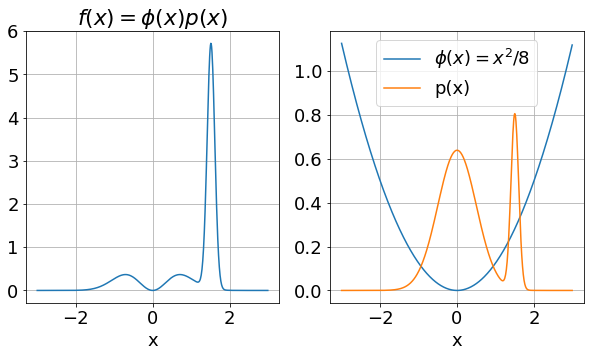

In [139]:
fig, axs = plt.subplots(1,2,figsize=(10,5))
x = np.arange(-3,3,0.01)
axs[0].plot(x,f(x))
axs[0].set_xlabel("x")
axs[0].set_title("$f(x)=\phi(x) p(x)$")
axs[0].grid();
axs[1].plot(x,phi(x),label="$\phi(x)=x^2/8$")
axs[1].plot(x,prob(x,norm=Z[0]),label="p(x)")
axs[1].set_xlabel("x")
axs[1].legend()
axs[1].grid();

In [140]:
@partial(jit, static_argnums=(0,1))
def Integ0(N, f, subkey):
    xi = jax.random.uniform(subkey, (N,), minval=-3,maxval=3)
    Z_hat = jnp.sum(prob(xi))
    return jnp.sum(f(xi))/Z_hat

In [141]:
key = jax.random.PRNGKey(42)
Ns = [1000,10000,100000,1000000]
for n in Ns: 
    key, subkey = jax.random.split(key)
    I0 = Integ0(n,f,subkey)
    print(n,(I0-Integ_true)/Integ_true)

1000 0.07876443
10000 0.0013863564
100000 -0.0028218045
1000000 -0.0008424184


In [142]:
key = jax.random.PRNGKey(20)
Ns = np.int_(10**np.arange(3,7,0.1))
info =[]
for n in Ns: 
    key, subkey = jax.random.split(key)
    I0 =  Integ0(n,f,subkey)
    info.append(I0)

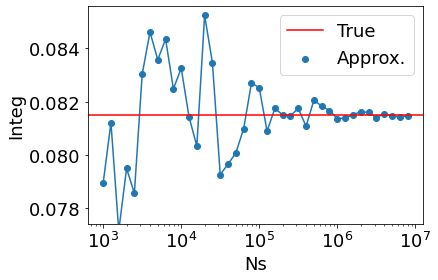

In [290]:
plt.scatter(Ns,np.array(info),label='Approx.')
plt.plot(Ns,np.array(info))
plt.axhline(y=Integ_true, color='r', linestyle='-',label='True')
plt.xscale('log')
plt.xlabel('Ns')
plt.ylabel('Integ')
plt.ylim([Integ_true*0.95,Integ_true*1.05])
plt.legend()
plt.show()


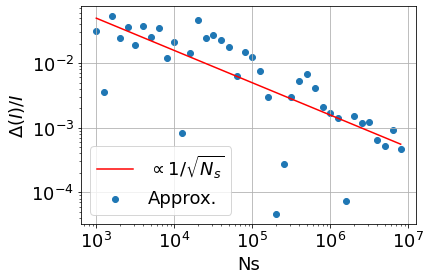

In [313]:
plt.scatter(Ns,np.abs(np.array(info)-Integ_true)/Integ_true,label='Approx.')
#plt.plot(Ns,np.abs(np.array(info)-Integ_true)/Integ_true)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Ns')
plt.ylabel('$\Delta(I)/I$')
plt.plot(Ns,0.035*np.sqrt(2e3/Ns),label='$\propto 1/\sqrt{N_s}$',c='r')
plt.grid()
plt.legend()
plt.show()

In [474]:
print(f"Ns       err. relat.")
for n in range(3,7):
    cut = (10**n<=Ns) & (Ns<10**(n+1))
    print(f"{np.mean(Ns[cut]):7.0f}\
 {(np.mean(np.array(info)[cut])-Integ_true)/Integ_true:15.6e}")

Ns       err. relat.
   3475   -1.944153e-03
  34758    1.715133e-03
 347590    1.857105e-03
3475904   -2.845480e-04


In [391]:
class Quadrature:
    """
    Base class for quadratures providing node lcations, the weights and error weights
    """

    def __init__(self, order=5):
        self.order = int(order)
        self.absc, self.absw, self.errw = self.ComputeAbsWeights()
        self.nPts = len(self.absc)

    def rescaleAbsWeights(self, xInmin=-1.0, xInmax=1.0, xOutmin=0.0, xOutmax=1.0):
        """
        Translate nodes,weights for [xInmin,xInmax] integral to [xOutmin,xOutmax]
        """
        deltaXIn = xInmax - xInmin
        deltaXOut = xOutmax - xOutmin
        scale = deltaXOut / deltaXIn
        self.absw *= scale
        tmp = jnp.array(
            [
                ((xi - xInmin) * xOutmax - (xi - xInmax) * xOutmin) / deltaXIn
                for xi in self.absc
            ]
        )
        self.absc = tmp
    

    def computeIntegral(self, func, bounds, return_error=True):
        """
        Integral computation of \int_a^b f(x) dx \approx  \sum_i w_i f(x_i)
        a = bounds[0] (scalar)
        b = bounds[1] (scalar)
        f(x) = func
        """
        a = bounds[0]
        b = bounds[1]
        d = b - a
        xi = a + self.absc * d
        fi = func(xi)

        #JEC 10/July/21 for multi-integrations broadcasting
        # nb: the first index is weight axis
        integ = d*jnp.einsum('i,i...',self.absw, fi)
        
        if return_error:
            return {
                "val": integ,
                "err": d * jnp.abs(jnp.einsum('i,i...',self.errw, fi)),
                "nodes": xi,
            }

        return integ
    
    def globalAdapStrat(self, func,bounds, tol=1.e-6, MaxIter=1000, MinIter=1):
        """
            Global adaptative strategy to compute int_a^b f(x) dx
            a = bounds[0]
            b = bounds[1]
            f(x) = func
            tol: error < tol*integral
            nbre of iterations is [MinIter, MinIter]
            The idea is to split an interval [ai,bi] if its error is the largest one and if the
            global error is larger the user tolerance 
        """
        curBounds=bounds
        curValues = self.computeIntegral(func,bounds)
        integral  = curValues['val']
        error     = curValues['err']
        curResult = [curBounds,[integral,error]]
        theResult = [curResult]
                
        nIter=0
        while ( ((error >= tol*jnp.abs(integral)) and (nIter<MaxIter)) or (nIter<MinIter)):
            nIter += 1
            curBounds =  theResult[-1][0] #last
            xMiddle = (curBounds[0]+curBounds[1])*0.5
            # [x0, mid]
            lowerB = [curBounds[0],xMiddle]
            valLow = self.computeIntegral(func,lowerB)
            resLow = [lowerB, [valLow['val'],valLow['err']]]
            # [mid, x1]
            upperB = [xMiddle,curBounds[1]]
            valUp  = self.computeIntegral(func,upperB)
            resUp  = [upperB, [valUp['val'],valUp['err']]]
            #
            theResult.pop() #remove laast element
            theResult.append(resLow)
            theResult.append(resUp)
            #sort: the last element [[a,b],[val,err]] has the largest "err"
            theResult=sorted(theResult,key=lambda x:x[1][1])
            #Collect the differente pieces
            tmp = jnp.array(theResult)
            integral = jnp.sum(tmp[:,1,0])
            error    = jnp.sum(tmp[:,1,1])
        return {'val':integral,'err':error, 'niter':nIter}


class ClenshawCurtisQuad(Quadrature):
    """
    Clenshaw-Curtis quadrature nodes and weights computed by FFT.
    nb. The order is transformed into a odd number just to get
    an error based on a sub-sampling of the quadrature
    """

    def __init__(self, order=5):
        # 2n-1 quad
        Quadrature.__init__(self, int(2 * order - 1))
        self.rescaleAbsWeights()  # rescale [-1,1] to [0,1]

    def ComputeAbsWeights(self):
        x, wx = self.absweights(self.order)
        nsub = (self.order + 1) // 2
        xSub, wSub = self.absweights(nsub)
        errw = wx
        errw = errw.at[::2].add(-wSub)
        return x, wx, errw

    def absweights(self, n):
        degree = n

        points = -jnp.cos((jnp.pi * jnp.arange(n)) / (n - 1))

        if n == 2:
            weights = jnp.array([1.0, 1.0])
            return points, weights

        n -= 1
        N = jnp.arange(1, n, 2)
        length = len(N)
        m = n - length
        v0 = jnp.concatenate([2.0 / N / (N - 2), np.array([1.0 / N[-1]]), np.zeros(m)])
        v2 = -v0[:-1] - v0[:0:-1]
        g0 = -jnp.ones(n)
        g0 = g0.at[length].add(n)
        g0 = g0.at[m].add(n)
        g = g0 / (n ** 2 - 1 + (n % 2))

        w = jnp.fft.ihfft(v2 + g)
        ###assert max(w.imag) < 1.0e-15
        w = w.real

        if n % 2 == 1:
            weights = jnp.concatenate([w, w[::-1]])
        else:
            weights = jnp.concatenate([w, w[len(w) - 2 :: -1]])

        # return
        return points, weights

In [397]:
quad = ClenshawCurtisQuad(80)
Integ_dict=quad.globalAdapStrat(lambda x: prob(x,norm=Z[0])*phi(x),[-3,3], tol=1.e-8, MaxIter=100)
print(f"Quad. CC {quad.nPts}pts: {Integ_dict['val']} +/- {Integ_dict['err']} ({Integ_dict['niter']} loops)")
print("Diff relat. avec scipy: ",(Integ_dict['val']-Integ_true)/Integ_true)

Quad. CC 159pts: 0.08149999825655685 +/- 2.244061094176214e-13 (1 loops)
Diff relat. avec scipy:  5.108388259394091e-16


# Importance Sampling

In [398]:
def qapp0(x):
    return 60*jax.scipy.stats.norm.pdf(x,scale=1.5)

In [399]:
def qapp(x):
    return 20*(jax.scipy.stats.norm.pdf(x,scale=0.5)+\
            jax.scipy.stats.norm.pdf(x-1.5,scale=0.5))

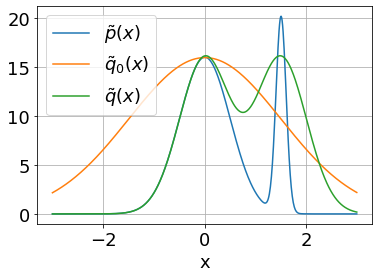

In [400]:
x = np.arange(-3,3,0.01)
plt.plot(x,prob(x), label=r"$\tilde{p}(x)$")
plt.plot(x,qapp0(x), label=r'$\tilde{q}_0(x)$')
plt.plot(x,qapp(x), label=r'$\tilde{q}(x)$')
plt.grid()
plt.legend()
plt.xlabel("x");

génération simple d'une distribution somme de 2 gaussiennes

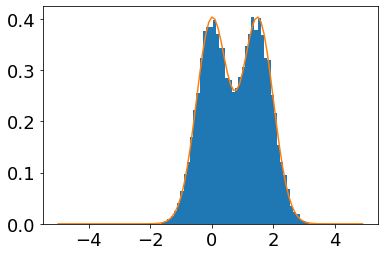

In [406]:
xs1 =  jax.random.normal(subkey, (10000,))*0.5
xs2 = jax.random.normal(subkey, (10000,))*0.5+1.5
xs=jnp.concatenate([xs1,xs2])
Zq,_ = integrate.quad(lambda x: qapp(x),-5, 5) 
xi = np.arange(-5,5,0.1)
plt.hist(xs,bins=50,density=True);
plt.plot(xi,qapp(xi)/Zq)

In [405]:
key = jax.random.PRNGKey(42)
@jax.partial(jit, static_argnums=1)
def importance_sampling(key,N):
    key, subkey = jax.random.split(key)
    xs1= jax.random.normal(subkey, (N//2,))*0.5
    xs2= jax.random.normal(subkey, (N//2,))*0.5+1.5
    x_Qrnd=jnp.concatenate([xs1,xs2])
    w = prob(x_Qrnd)/qapp(x_Qrnd)
    norm = jnp.sum(w)
    phi_samples=phi(x_Qrnd)
    integ = jnp.dot(w/norm,phi_samples)
    return integ,w, key

@jax.partial(jit, static_argnums=1)
def importance_sampling_0(key,N):
    key, subkey = jax.random.split(key)
    x_Qrnd=jax.random.normal(subkey, (N,))*1.5
    w = prob(x_Qrnd)/qapp0(x_Qrnd)
    norm = jnp.sum(w)
    phi_samples=phi(x_Qrnd)
    integ = jnp.dot(w/norm,phi_samples)
    return integ,w, key


In [407]:
Integ_is,Ws0,_= importance_sampling_0(key,100000)
print(f"$I_{{is}}^0$ = {Integ_is:.6e};\
  \trelat. err ={np.abs(Integ_is-Integ_true)/Integ_true:.6e}")

Integ_is,Ws,_= importance_sampling(key,100000)
print(f"$I_{{is}}$ = {Integ_is:.6e};\
  \trelat. err ={np.abs(Integ_is-Integ_true)/Integ_true:.6e}")

$I_{is}^0$ = 8.151243e-02;  	relat. err =1.525168e-04
$I_{is}$ = 8.108702e-02;  	relat. err =5.067226e-03


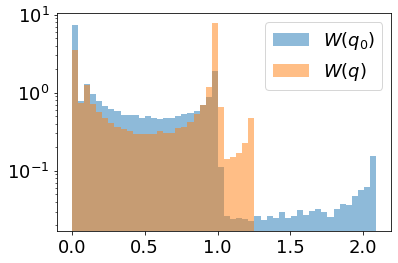

In [408]:
_,bins,_=plt.hist(Ws0,bins=50,alpha=0.5,density=True,label='$W(q_0)$');
plt.hist(Ws,bins=bins,alpha=0.5,density=True,label='$W(q)$');
plt.yscale('log')
plt.legend();

In [409]:
key = jax.random.PRNGKey(20)
Ns = np.int_(10**np.arange(3,7,0.1))
infoI1_0 =[]
infoI1 =[]
for n in Ns: 
    I1_0,_,key =  importance_sampling_0(key,n)
    I1,_,key =  importance_sampling(key,n)
    infoI1_0.append(I1_0)
    infoI1.append(I1)

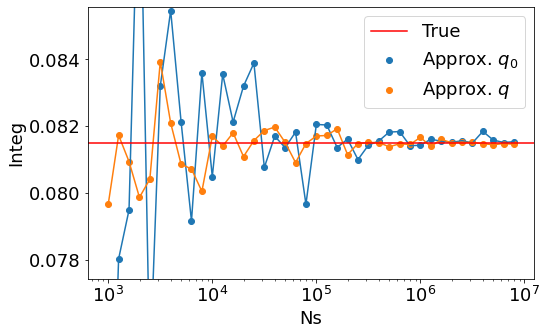

In [410]:
fig,_=plt.subplots(figsize=(8,5))
plt.scatter(Ns,np.array(infoI1_0),label='Approx. $q_0$')
plt.plot(Ns,np.array(infoI1_0))
plt.scatter(Ns,np.array(infoI1),label='Approx. $q$')
plt.plot(Ns,np.array(infoI1))
plt.axhline(y=Integ_true, color='r', linestyle='-',label='True')
plt.xscale('log')
plt.xlabel('Ns')
plt.ylabel('Integ')
plt.ylim([Integ_true*0.95,Integ_true*1.05])
plt.legend()
plt.show()


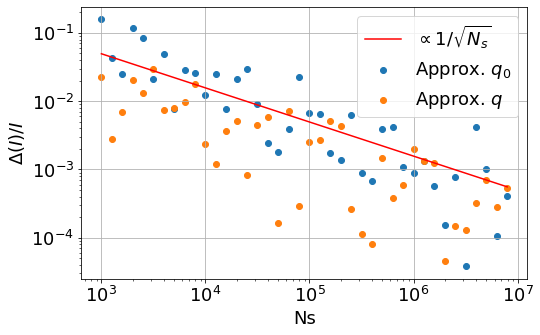

In [413]:
fig,_=plt.subplots(figsize=(8,5))
plt.scatter(Ns,np.abs(np.array(infoI1_0)-Integ_true)/Integ_true,label='Approx. $q_0$')
plt.scatter(Ns,np.abs(np.array(infoI1)-Integ_true)/Integ_true,label='Approx. $q$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Ns')
plt.ylabel('$\Delta(I)/I$')
plt.plot(Ns,0.035*np.sqrt(2e3/Ns),label='$\propto 1/\sqrt{N_s}$',c='r')
plt.grid()
plt.legend()
plt.show()

In [473]:
print(f"Ns       err. relat. q_0   err. relat. q")
for n in range(3,7):
    cut = (10**n<=Ns) & (Ns<10**(n+1))
    print(f"{np.mean(Ns[cut]):7.0f}\
 {(np.mean(np.array(infoI1_0)[cut])-Integ_true)/Integ_true:15.6e}\
  {(np.mean(np.array(infoI1)[cut])-Integ_true)/Integ_true:15.6e}"
         )

Ns       err. relat. q_0   err. relat. q
   3475   -1.180288e-02    -5.843183e-03
  34758    4.347754e-03     3.477811e-04
 347590    1.354056e-03     3.500200e-04
3475904    7.614226e-04     3.757995e-05


## En dimension N

In [950]:
@jit
def prob_nD(x,R=1):
    r  = jnp.linalg.norm(x,axis=1)
    return jnp.where(r<R,1,0)

In [951]:
@partial(jit, static_argnums=2)
def qapp_nD(x,s=1):
    dim = x.shape[1]
    return jax.scipy.stats.multivariate_normal.pdf(x,np.zeros(dim),
                                            s**2*np.identity(dim))

Où sont localisés les points tirées selon une loi gaussienne en dimension $d$?

In [1022]:
key = jax.random.PRNGKey(0)
N=10_000
dims = jnp.array([10,20,50,100,200,500,1000])
s=1
info1 = []
info2 = []
for dim in dims:
    key, subkey = jax.random.split(key)
    data = jax.random.multivariate_normal(subkey,
                                        np.zeros(dim),
                                        s**2*np.identity(dim),
                                        (N,))
    r = jnp.linalg.norm(data,axis=1)
    info1.append(jnp.mean(r))
    info2.append(jnp.std(r))

Text(0.5, 0, 'r')

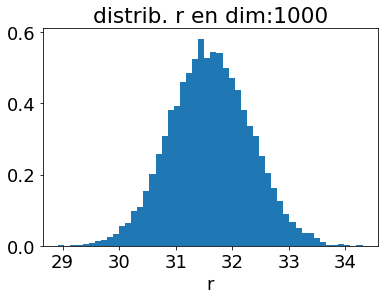

In [1025]:
plt.hist(r,bins=50,density=True);
plt.title(f"distrib. r en dim:{dim}")
plt.xlabel("r")

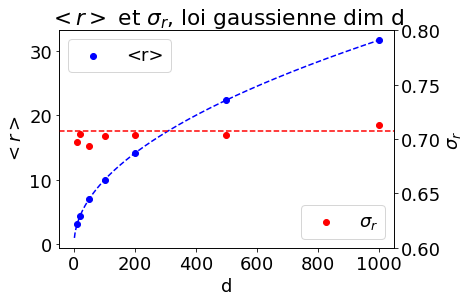

In [1050]:
fig, ax = plt.subplots()
axes = [ax, ax.twinx()]
axes[0].scatter(dims,info1,c='b',label="<r>");
xi = np.arange(1,1000,0.1)
axes[0].plot(xi,np.sqrt(xi),c='b',ls="--")
axes[0].set_xlabel("d")
axes[0].set_ylabel("$<r>$")
axes[1].scatter(dims,info2,c='r',label="$\sigma_r$");
axes[1].axhline(y=1/np.sqrt(2), color='r', linestyle='--')
axes[1].set_ylim([0.6,0.8])
axes[1].set_ylabel("$\sigma_r$")
plt.title("$<r>$ et $\sigma_r$, loi gaussienne dim d");
axes[0].legend(loc='upper left');
axes[1].legend(loc="lower right");

In [952]:
@jit
def phi_nD(x):
    r  = jnp.linalg.norm(x,axis=1)
    return r*r

In [1053]:
@partial(jit, static_argnums=(1,2))
def importance_sampling_nD(key,N,dim=2,R=1,s=1):
    key, subkey = jax.random.split(key)
    x_Qrnd = jax.random.multivariate_normal(subkey,
                                            np.zeros(dim),
                                            s**2*np.identity(dim),
                                            (N,))
    
    w = prob_nD(x_Qrnd,R)/qapp_nD(x_Qrnd,s)
    norm = jnp.sum(w)
    w /= norm
    phi_samples=phi_nD(x_Qrnd)
    integ = jnp.dot(w,phi_samples)
    return key,integ,w

In [1054]:
def integ_true_nD(dim,R=1):
    return R**2*dim/(dim+2)

In [1071]:
key = jax.random.PRNGKey(0)
Ns = 10_000
dim = 400
R = 1
sigma = R/np.sqrt(dim)
_,integ_is,w = importance_sampling_nD(key,Ns,dim=dim,R=R,s=sigma)
print("Integ=", integ_is,integ_true_nD(dim))
w_max = jnp.max(w)
w_med = jnp.median(w)
print(f"w max: {w_max:.6e}, med: {w_med:.6e}, max/med: {w_max/w_med:.6e}")

Integ= 0.9953479439581329 0.9950248756218906
w max: 3.394031e-03, med: 5.229276e-16, max/med: 6.490442e+12


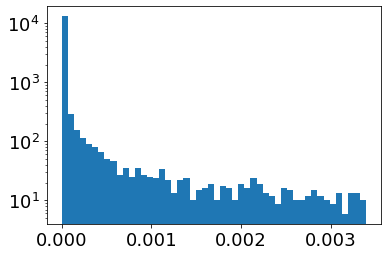

In [1075]:
plt.hist(w,bins=50,density=True);
plt.yscale('log')

In [1066]:
def test(dim):
    key = jax.random.PRNGKey(0)
    Ns = 10_000
    R = 1
    sigma = R/jnp.sqrt(dim)
    _,integ,w = importance_sampling_nD(key,Ns,dim=dim,R=R,s=sigma)
    w_max = jnp.max(w)
    w_med = jnp.median(w)
    return integ,w_max/w_med

In [1067]:
dims = np.array([1,2,5,10,20,30,40,50,100,200,300,400])

In [1068]:
info = []
for d in dims:
    _,val = test(d)
    info.append(val)

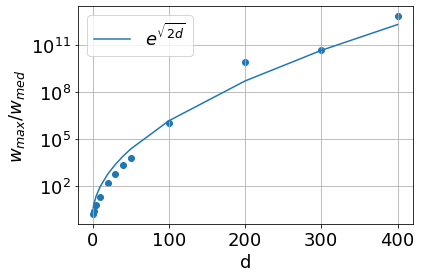

In [1076]:
plt.scatter(dims,info)
plt.yscale('log')
plt.plot(dims,np.exp(np.sqrt(2*dims)),label="$e^{\sqrt{2d}}$")
plt.xlabel("d")
plt.ylabel("$w_{max}/w_{med}$")
plt.grid()
plt.legend()
plt.show()

# Metropolis-Hastings method

## Simple cas en 1D, multi-chaines (Numpy)

In [1195]:
class MixtureModel(scs.rv_continuous):
    def __init__(self, submodels, weights, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.submodels = submodels
        weights   = np.array(weights)
        norm = np.sum(weights)
        self.weights = weights/norm
        self.num_distr = len(submodels)
        #print(self.num_distr, self.weights,self.submodels)
        

    def _pdf(self, x):
        pdf = 0.
        for i, submodel in enumerate(self.submodels):
            pdf += self.weights[i]*submodel.pdf(x)
            
        return pdf

    # Random generation to compare with Metropolis sampling
    def rvs(self, sample_size):
        random_idx = np.random.choice(np.arange(self.num_distr), size=(sample_size,), p=self.weights)
        submodel_samples = [submodel.rvs(size=sample_size) for submodel in self.submodels]
        print(np.array(submodel_samples).shape)
        rvs = np.choose(random_idx, submodel_samples)
        return rvs

In [1196]:
# somme de 2 gaussiennes
mixture_gaussian_model = MixtureModel([scs.norm(loc=0, scale=0.5), 
                                       scs.norm(loc=1.5, scale=0.2)],
                                      [8,2])

In [1197]:
def phi(x):
    return x**2

## 

In [1222]:
def MHSampling_v2p(proba,Ns=100_000,Nchain=10,scale=0.1, forget=25_000):
    # Ns nbre de samples per chain
    samples = []
    # forget a fixed number of samples for each chain
    Ns = Ns + forget
    current = scs.uniform.rvs(loc=-3,scale=6, size=(Nchain,))
    for i in range(Ns):
        samples.append(current.copy())
        #proposal in [current-scale,current+scale]
        proposal = scs.uniform.rvs(loc=current-scale,scale=2*scale, size=(Nchain,))
        # proposal distrib is symetric: q(x_c,x_p)=q(x_c-x_p)=q(x_p,x_c)
        r = proba(proposal)/proba(current)  
        u = scs.uniform.rvs(size=(Nchain,))
        mask = r>u #accept proposal
        current[mask] = proposal[mask]

    #return all chains with the first "forget" samples rejected
    samples = np.array(samples).T
    return samples[:,forget:]

In [1190]:
spls = MHSampling_v2p(lambda x: mixture_gaussian_model.pdf(x),
                            Ns=100_000, Nchain=100, forget=25000, scale=0.1
                           )

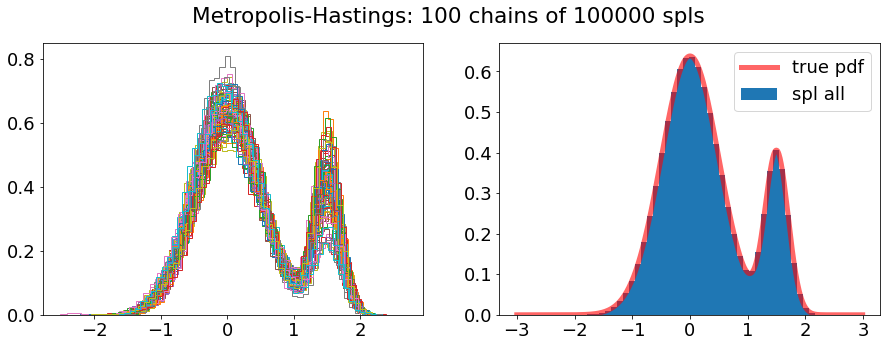

In [1228]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
for i in range(spls.shape[0]):
    axs[0].hist(spls[i],bins=50, density=True, histtype='step',label=f"spl [{i}]");
#axs[0].plot(x_axis, mixture_gaussian_model.pdf(x_axis),'r-', lw=5, alpha=0.6, label='true pdf')
#axs[0].legend(loc='upper right')
#
axs[1].hist(spls.flatten(),bins=50, density=True,label=f"spl all");
x_axis = np.arange(-3, 3, 0.01)
axs[1].plot(x_axis, mixture_gaussian_model.pdf(x_axis),'r-', lw=5, alpha=0.6, label='true pdf')
axs[1].legend()
fig.suptitle(f"Metropolis-Hastings: {spls.shape[0]} chains of {spls.shape[1]} spls")

plt.show()

In [1239]:
spl_all= spls.flatten()
phi_spl = phi(spl_all)
Integ_M = np.mean(phi_spl)

In [1240]:
print(f"Integ ({spl_all.shape[0]:.0e} spl): {Integ_M:.6e}")

Integ (1e+07 spl): 6.580126e-01


In [1234]:
Integ_true,_=integrate.quad(lambda x: phi(x)*mixture_gaussian_model.pdf(x),-3,3)

In [1236]:
Integ_true

0.6579999850231879

In [1243]:
(Integ_M-Integ_true)/Integ_true

1.918786659422559e-05

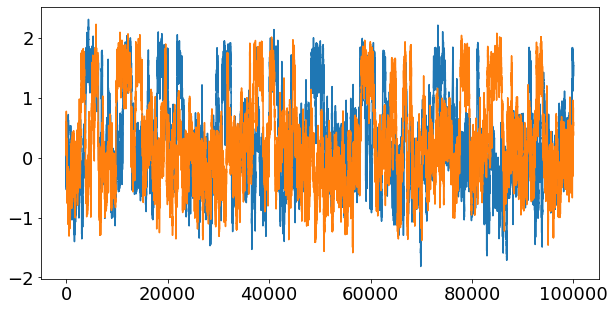

In [1221]:
fig = plt.figure(figsize=(10,5))
plt.plot(spls[0])
plt.plot(spls[1])


## Version avec les logprob et implementee en Jax

In [2]:
class MixtureModel_jax():
    def __init__(self, locs, scales, weights, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.loc = jnp.array([locs]).T
        self.scale = jnp.array([scales]).T
        self.weights = jnp.array([weights]).T
        norm = jnp.sum(self.weights)
        self.weights = self.weights/norm

        self.num_distr = len(locs)

    def pdf(self, x):
        probs = jax.scipy.stats.norm.pdf(x,loc=self.loc, scale=self.scale)
        return jnp.dot(self.weights.T,probs).squeeze()
        
    def logpdf(self, x):
        log_probs = jax.scipy.stats.norm.logpdf(x,loc=self.loc, scale=self.scale)
        return jax.scipy.special.logsumexp(jnp.log(self.weights) + log_probs, axis=0)


In [3]:
mixture_gaussian_model = MixtureModel_jax([0,1.5],[0.5,0.1],[8,2])

In [4]:
@partial(jax.jit, static_argnums=(1,))
def jax_metropolis_kernel(rng_key, logpdf, position, log_prob):
    key, subkey = jax.random.split(rng_key)
    """Moves the chain by one step using the Random Walk Metropolis algorithm.
  
    Attributes
    ----------
    rng_key: jax.random.PRNGKey
      Key for the pseudo random number generator.
    logpdf: function
      Returns the log-probability of the model given a position.
    position: np.ndarray, shape (n_dims,)
      The starting position.
    log_prob: float
      The log probability at the starting position.

    Returns
    -------
    Tuple
        The next positions of the chains along with their log probability.
    """
    move_proposals = jax.random.normal(key, shape=position.shape) * 0.1
    proposal = position + move_proposals
    proposal_log_prob = logpdf(proposal)

    log_uniform = jnp.log(jax.random.uniform(subkey))
    do_accept = log_uniform < proposal_log_prob - log_prob

    position = jnp.where(do_accept, proposal, position)
    log_prob = jnp.where(do_accept, proposal_log_prob, log_prob)
    return position, log_prob

@partial(jax.jit, static_argnums=(1, 2))
def jax_metropolis_sampler(rng_key, n_samples, logpdf, initial_position):
    """Generate samples using the Random Walk Metropolis algorithm.
    Attributes
    ----------
    rng_key: jax.random.PRNGKey
        Key for the pseudo random number generator.
    n_samples: int
        Number of samples to generate per chain.
    logpdf: function
      Returns the log-probability of the model given a position.
    inital_position: np.ndarray (n_dims, n_chains)
      The starting position.
    Returns
    -------
    (n_samples, n_dim)
    """
    def mh_update(i, state):
        key, positions, log_prob = state
        _, key = jax.random.split(key)
        new_position, new_log_prob = jax_metropolis_kernel(key, 
                                                           logpdf, 
                                                           positions[i-1], 
                                                           log_prob)
        positions=positions.at[i].set(new_position)
        return (key, positions, new_log_prob)


    logp = logpdf(initial_position)
    # all positions structure should be set before lax.fori_loop
    
    all_positions = jnp.zeros((n_samples,initial_position.shape[0]))  # 1 chain for each vmap call
    
    initial_state = (rng_key,all_positions, logp)
    rng_key, all_positions, log_prob = jax.lax.fori_loop(1, n_samples, 
                                                 mh_update, 
                                                 initial_state)
    
    
    return all_positions

In [10]:
n_dim = 1
n_forget = 25_000
n_samples = 100_000 + n_forget
n_chains = 1_000

rng_key = jax.random.PRNGKey(42)

rng_keys = jax.random.split(rng_key, n_chains)
initial_position = jnp.zeros((n_dim, n_chains))

run_mcmc = jax.vmap(jax_metropolis_sampler, 
                    in_axes=(0, None, None, 1),
                    out_axes=0)
all_positions = run_mcmc(rng_keys, n_samples, 
                     lambda x: mixture_gaussian_model.logpdf(x), 
                     initial_position)

all_positions = all_positions.squeeze()

all_positions=np.asarray(all_positions[:,25_000:])

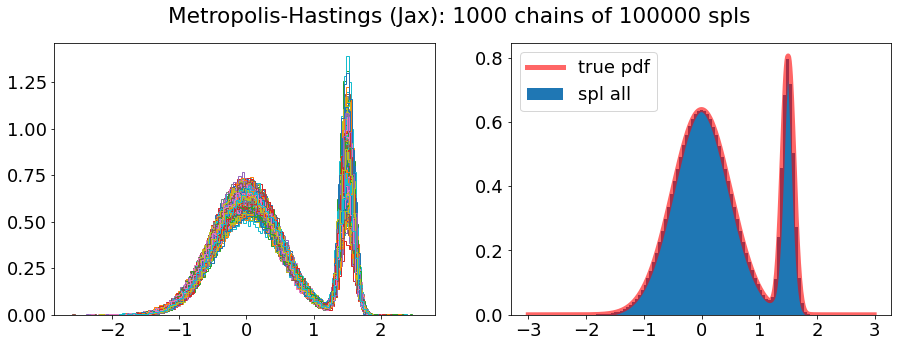

In [11]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
for i in range(all_positions.shape[0]):
    axs[0].hist(all_positions[i],bins=100, density=True, histtype='step',label=f"spl [{i}]");
#axs[0].plot(x_axis, mixture_gaussian_model.pdf(x_axis),'r-', lw=5, alpha=0.6, label='true pdf')
#axs[0].legend(loc='upper right')
#
axs[1].hist(all_positions.flatten(),bins=100, density=True,label=f"spl all");
x_axis = np.arange(-3, 3, 0.01)
axs[1].plot(x_axis, mixture_gaussian_model.pdf(x_axis),'r-', lw=5, alpha=0.6, label='true pdf')
axs[1].legend()
fig.suptitle(f"Metropolis-Hastings (Jax): {all_positions.shape[0]} chains of {all_positions.shape[1]} spls")

plt.show()

## Estimation de  parametres: 3 dim

In [2]:
sample_size = 5_000
sigma_e = 1.5             # true value of parameter error sigma
random_num_generator = np.random.RandomState(0)
xi = 10.0 * random_num_generator.rand(sample_size)
e = random_num_generator.normal(0, sigma_e, sample_size)
yi = 1.0 + 2.0 * xi +  e          # a = 1.0; b = 2.0; y = a + b*x

In [3]:
def lik(parameters, X, Y):
    m = parameters[1]
    b = parameters[0]
    sigma = parameters[2]
    y_exp = m * X + b
    L = len(X)/2 * np.log(2 * np.pi * sigma ** 2) \
         + 1/(2 * sigma ** 2) * sum((Y - y_exp) ** 2)
    return L

In [4]:

lik_model = minimize(lik, np.array([1,1,1]), args=(xi,yi), method='L-BFGS-B')
print(lik_model['x'])

[0.98725158 1.99939789 1.47958158]


In [5]:
mini=lik_model['x']
df_mini = pd.DataFrame(mini[np.newaxis,:],columns=["bias","slope","sigma"])
df_mini["chain"]="Min Scipy"

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


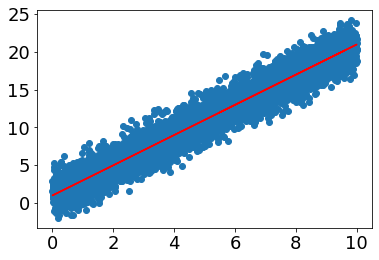

In [6]:
plt.scatter(xi,yi)
plt.plot(xi, lik_model['x'][1] * xi + lik_model['x'][0],c='r')
plt.show()

In [58]:
@partial(jax.jit, static_argnums=(1,))
def jax_metropolis_kernel(rng_key, logpdf, position, log_prob):
    key, subkey = jax.random.split(rng_key)
    """Moves the chain by one step using the Random Walk Metropolis algorithm.
    """
    move_proposals = jax.random.normal(key, shape=position.shape) * 0.1
        
    proposal = position + move_proposals
    proposal_log_prob = logpdf(proposal)

    log_uniform = jnp.log(jax.random.uniform(subkey))
    do_accept = log_uniform < proposal_log_prob - log_prob

    position = jnp.where(do_accept, proposal, position)
    log_prob = jnp.where(do_accept, proposal_log_prob, log_prob)
    return position, log_prob

@partial(jax.jit, static_argnums=(1, 2))
def jax_metropolis_sampler(rng_key, n_samples, logpdf, initial_position):
    """Generate samples using the Random Walk Metropolis algorithm.
    """
    def mh_update(i, state):
        key, positions, log_prob = state
        _, key = jax.random.split(key)
                
        new_position, new_log_prob = jax_metropolis_kernel(key, 
                                                           logpdf, 
                                                           positions[i-1], 
                                                           log_prob)
                
        
        positions=positions.at[i].set(new_position)
        return (key, positions, new_log_prob)

    #Initialisation
    all_positions = jnp.zeros((n_samples,initial_position.shape[0]))  # 1 chain for each vmap call    ?
    all_positions=all_positions.at[0,0].set(scs.norm.rvs(loc=1,scale=1))
    all_positions=all_positions.at[0,1].set(scs.norm.rvs(loc=2,scale=1))
    all_positions=all_positions.at[0,2].set(scs.uniform.rvs(loc=1,scale=2))

    logp = logpdf(all_positions[0])
    
    initial_state = (rng_key,all_positions, logp)
    rng_key, all_positions, log_prob = jax.lax.fori_loop(1, n_samples, 
                                                 mh_update, 
                                                 initial_state)
    
    return all_positions
    

In [59]:
def jax_my_logpdf(par,xi,yi):
    # priors: a=par[0], b=par[1], sigma=par[2]
    logpdf_a = jax.scipy.stats.norm.logpdf(x=par[0],loc=0.5,scale=1.)
    logpdf_b = jax.scipy.stats.norm.logpdf(x=par[1],loc=2.5,scale=1.)
    logpdf_s = jax.scipy.stats.gamma.logpdf(x=par[2],a=3,scale=1.)

    val = xi*par[1]+par[0]
    tmp = jax.scipy.stats.norm.logpdf(x=val,loc=yi,scale=par[2])    
    log_likeh= jnp.sum(tmp)
    
    return log_likeh + logpdf_a + logpdf_b + logpdf_s

In [60]:
n_dim = 3
n_forget = 1_000
n_samples = 100_000 + n_forget
n_chains = 100
rng_key = jax.random.PRNGKey(42)


rng_keys = jax.random.split(rng_key, n_chains)    # generate an array of size (n_chains, 2)
initial_position = jnp.ones((n_dim, n_chains))    # generate an array of size (n_dim, n_chains)
                                                  # so for vmap one should connect axis 0 of rng_keys  
                                                  # and axis 1 of initial_position

#print("main initial_position shape",initial_position.shape)

run_mcmc = jax.vmap(jax_metropolis_sampler, 
                    in_axes=(0, None, None, 1),   # see comment above 
                    out_axes=0)                   # output axis 0 hold the vectorization over n_chains
                                                  # => (n_chains, n_samples, n_dims)


all_positions = run_mcmc(rng_keys, n_samples, 
                     lambda par: jax_my_logpdf(par,xi,yi), 
                     initial_position)

# Code below is just to plot afterwards the results thanks to Pandas DF
all_positions=np.asarray(all_positions)
#transform to N_samples, Npar, Ndim  arrray
all_positions=np.moveaxis(all_positions, 0, -1)
#forget the first samples
all_positions = all_positions[n_forget:]


In [61]:
# Exemple usage de seaborn PairGrid via un DataFrame Pandas
N, M, L = all_positions.shape
a_new = all_positions.transpose(0, 2, 1).reshape(N*L, M, order="F")
extra_column = np.repeat(np.arange(L), N)
res2 = np.column_stack((a_new, extra_column))
df_res2 = pd.DataFrame(res2,columns=["bias","slope","sigma","chain"])
df_res2['chain']=df_res2['chain'].map(int).map(str)

In [62]:
full_df_2 = pd.concat([df_res2, df_mini], ignore_index=True)

/sps/lsst/users/campagne/anaconda3/envs/jaxcosmo/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/sps/lsst/users/campagne/anaconda3/envs/jaxcosmo/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/sps/lsst/users/campagne/anaconda3/envs/jaxcosmo/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


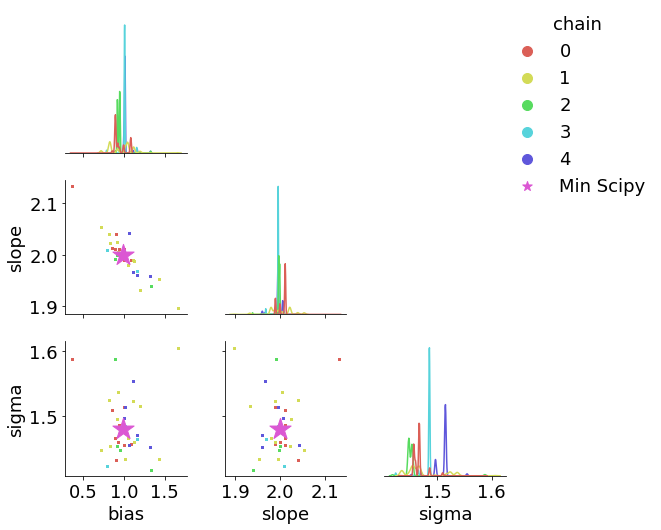

In [63]:
g = sns.PairGrid(full_df_2[full_df_2["chain"].str.fullmatch('0|1|2|3|4|Min Scipy')], 
                 diag_sharey=False,
                 hue="chain",
                 hue_kws={"s": [2]*5+[500], "marker": ["o"]*5+ ["*"]},
                 corner=True, 
                 palette="hls")
g.map_lower(plt.scatter)
g.map_diag(sns.kdeplot)
g.add_legend(loc='upper right', ncol=1)
for lh in g._legend.legendHandles: 
    lh.set_alpha(1)
    lh._sizes = [100]

In [64]:
all_biass = df_res2["bias"]
all_slopes= df_res2["slope"]
all_sigmas= df_res2["sigma"]
bias_sci = lik_model['x'][0]
slope_sci  = lik_model['x'][1]
sigma_sci = lik_model['x'][2]

In [65]:
from matplotlib.gridspec import GridSpec

In [66]:
def plot_histogram_fig(ax, param, nbins):
    counts, bins = np.histogram(param, bins = nbins)
    plotcounts = np.insert(counts, -1, counts[-1])
    bincentres = (bins[:-1] + bins[1:])/2
    ax.plot(bincentres, counts, 'b')
    
def plot_contour_fig(ax, p1, p2, nbins):
    H, xedges, yedges = np.histogram2d(p1, p2, bins = nbins)
    Z = H.T
    X, Y = np.meshgrid(xedges[:-1], yedges[:-1])
    im = ax.contour(X, Y, Z, levels = 6)
    ax.clabel(im, inline=True, fontsize=4)

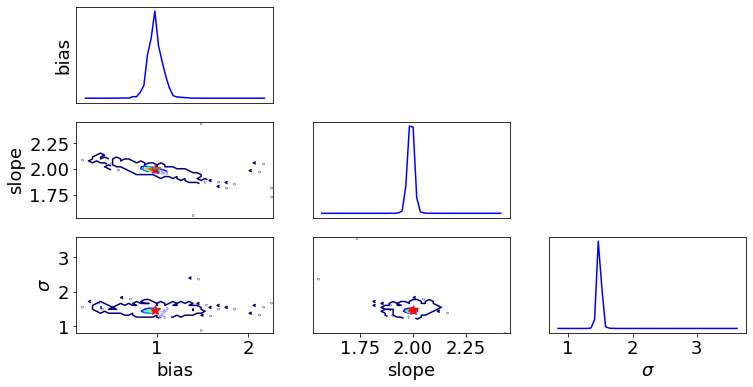

In [67]:
nbins=50
fig = plt.figure(figsize = (12, 6))
gs1 = GridSpec(3, 3, wspace=0.2)
ax00 = fig.add_subplot(gs1[0, 0])
plot_histogram_fig(ax00,all_biass, nbins)
ax00.set_xticks([])
ax00.set_yticks([])
ax00.set_ylabel('bias')

ax10 = fig.add_subplot(gs1[1, 0])
plot_contour_fig(ax10, all_biass, all_slopes, nbins)
ax10.plot(bias_sci,slope_sci,'*r',markersize=10)
ax10.set_xticks([])
ax10.set_ylabel('slope')

ax11 = fig.add_subplot(gs1[1, 1])
plot_histogram_fig(ax11,all_slopes, nbins)
ax11.set_xticks([])
ax11.set_yticks([])

ax20 = fig.add_subplot(gs1[2, 0])
plot_contour_fig(ax20, all_biass, all_sigmas, nbins)
ax20.plot(bias_sci,sigma_sci,'*r',markersize=10)
ax20.set_xlabel('bias')
ax20.set_ylabel('$\sigma$')

ax21 = fig.add_subplot(gs1[2, 1])
plot_contour_fig(ax21, all_slopes, all_sigmas, nbins)
ax21.plot(slope_sci,sigma_sci,'*r',markersize=10)
ax21.set_xlabel('slope')
ax21.set_yticks([])

ax22= fig.add_subplot(gs1[2, 2])
plot_histogram_fig(ax22,all_sigmas, nbins)
ax22.set_yticks([])
ax22.set_xlabel('$\sigma$')

plt.show()

In [68]:
df_res2.describe()

,bias,slope,sigma
count,1.000000e+07,1.000000e+07,1.000000e+07
mean,9.844716e-01,1.999085e+00,1.482840e+00
std,8.997088e-02,1.572301e-02,3.139239e-02
min,1.225824e-01,1.526846e+00,8.149707e-01
25%,9.277393e-01,1.989391e+00,1.464472e+00
50%,9.767593e-01,1.999538e+00,1.482997e+00
75%,1.036679e+00,2.007015e+00,1.501098e+00
max,2.321054e+00,2.475152e+00,3.652788e+00
